Group Member:
LI Jiaying 3035343164
Zhang Xinyi 3035234571
Zhang Renzhi 3035233591

# Abstract

in this project, we proposed to use Gradient Boosting without feature engineering to be the most accurate model; and Decision Tree to be a balanced model between interpretability and accuracy

# Read libararys

In [0]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install scorecardpy
import scorecardpy as sc
import matplotlib.pyplot as plt
# show plots automatically
%matplotlib inline

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
!pip install pygam
from pygam import LogisticGAM,f,s
from sklearn.linear_model import LinearRegression
from patsy import dmatrix
import warnings
warnings.filterwarnings("ignore")

     |████████████████████████████████| 61kB 3.0MB/s 
  Created wheel for scorecardpy: filename=scorecardpy-0.1.9.1.1-cp36-none-any.whl size=58169 sha256=a22325502a786ee92fa373b2b44f1d89e64d70ef64355ad2177ec360ae4d18e6
  Stored in directory: /root/.cache/pip/wheels/8f/4c/98/567ff70984acd88ffae211d8fc209e34b98fb43ff27f09fdd3
Successfully built scorecardpy
     |████████████████████████████████| 1.8MB 4.8MB/s 


# Load Data

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HELOC/HelocData.csv')

In [20]:
data_dict = pd.read_csv("/content/drive/My Drive/Colab Notebooks/HELOC/B.csv")
var_names = data_dict.iloc[:,1]
var_names.name = 'Description'
var_names.to_frame()

,Description
0,Paid as negotiated flag (12-36 Months). String...
1,Consolidated version of risk markers
2,Months Since Oldest Trade Open
3,Months Since Most Recent Trade Open
4,Average Months in File
5,Number Satisfactory Trades
6,Number Trades 60+ Ever
7,Number Trades 90+ Ever
8,Percent Trades Never Delinquent
9,Months Since Most Recent Delinquency


#Data Preprocessing

## 1. Data Cleaning

**Missing Values**



RiskFlag     0.00%
x1           5.72%
x2           7.91%
x3           5.62%
x4           5.62%
x5           5.62%
x6           5.62%
x7           5.62%
x8           5.62%
x9          51.90%
x10          5.62%
x11          5.62%
x12          5.62%
x13          5.62%
x14          5.62%
x15         27.91%
x16          5.62%
x17          5.62%
x18          7.40%
x19         38.31%
x20          7.11%
x21         13.85%
x22         11.20%
x23          5.79%
dtype: object


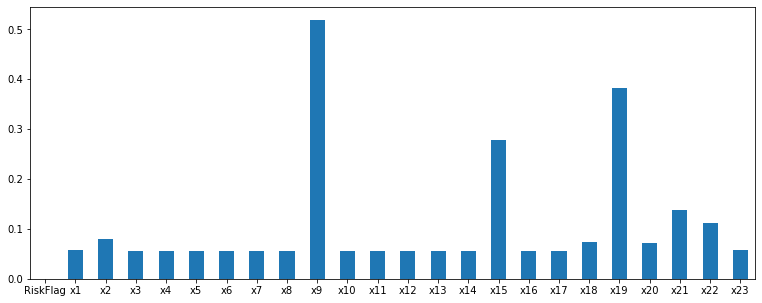

In [0]:
import matplotlib.pyplot as plt
psg_num = df.shape[0]
missingdata = df[(df == -7) | (df == -8) | (df == -9)].count()/psg_num
print((missingdata).apply(lambda x: format(x, '.2%')))
missingdata.plot.bar(x = 'missing data', y = missingdata, rot = 0, figsize = (13, 5))
plt.show()

Taking a closer look in the missing value of the data set, we found there are 588 samples with all variables = -9 (missing value). 
 

We believe they carries no value of information and should be deleted at the beginning.

In [21]:
for index, row in df.iterrows():
    if sum([np.sqrt(-x) for x in row[1:].values]) == 69:
        df.at[index,'x24']=np.nan
    else:
        df.at[index,'x24']=1
df.dropna(inplace=True)
df=df.iloc[:,:-1]
df.replace(-7,np.nan,inplace=True)
df.replace(-8,np.nan,inplace=True)
df.replace(-9,np.nan,inplace=True)
df.shape
df.head()

,RiskFlag,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23
0,Bad,75.0,169.0,2,59,21,0,0,100,NaN,7,8,22,4,36,NaN,4,4,43.0,112.0,4.0,6.0,0.0,83.0
1,Bad,66.0,502.0,4,145,34,0,0,97,36.0,6,6,37,4,27,4.0,3,3,80.0,53.0,17.0,3.0,12.0,83.0
2,Good,69.0,338.0,2,62,22,0,0,96,12.0,6,6,23,3,35,0.0,4,4,25.0,100.0,3.0,2.0,1.0,45.0
3,Good,75.0,422.0,1,91,55,0,0,100,NaN,7,8,57,4,33,0.0,4,4,2.0,11.0,12.0,2.0,1.0,57.0
4,Bad,63.0,242.0,2,68,25,0,0,100,NaN,7,8,26,1,19,NaN,3,3,73.0,NaN,12.0,1.0,5.0,87.0


## 2. Variable Selection

* Using the Graph above, we found that there are two variables containing over 38% missing values, namely `x9` and `x19`.

  We believe these two variables should be deleted in the beginning to enhance the information density


* Then, we did a rough variable selection by running three black box models, `Multi-layer perceptron (MLP) classifier`, `support vector classifiers`, and `gradient boosting machines` with the remaining 21 variables. Based on their post-hoc analysis of VI, we concluded that 9 variables (`x6`, `x7`, `x10`, `x11`, `x13`, `x16`, `x17`, `x21`, `x22`) are collectively evaluated to be of limited importance in all the three models. 

  Thus, we decided to drop these 9 variables to enhance the sparsity of the model.


In [0]:
# drop unuseful columns and keep only useful features: x1, x5, x16, x17, x20
df_tmp = df.copy()

df_tmp.drop('x6', axis = 1, inplace = True)
df_tmp.drop('x7', axis = 1, inplace = True)
df_tmp.drop('x10', axis = 1, inplace = True)
df_tmp.drop('x11', axis = 1, inplace = True)
df_tmp.drop('x13', axis = 1, inplace = True)
df_tmp.drop('x16', axis = 1, inplace = True)
df_tmp.drop('x17', axis = 1, inplace = True)
df_tmp.drop('x21', axis = 1, inplace = True)
df_tmp.drop('x22', axis = 1, inplace = True)
df_tmp.drop('x9', axis = 1, inplace = True)
df_tmp.drop('x19', axis = 1, inplace = True)

df = df_tmp

## 3. Data Split

In [23]:
# Split the data into training and testing sets with UID as the random seed
np.random.seed(20190016) 
df_train, df_test = train_test_split(df, test_size=0.2)

train_size = df_train.shape[0]/df.shape[0]
test_size = df_test.shape[0]/df.shape[0]
print('Proportion of training set: {:.2f}%'.format(train_size))
print('Proportion of training set: {:.2f}%'.format(test_size))

Proportion of training set: 0.80%
Proportion of training set: 0.20%


## 4. Imputation

In [0]:
# handling missing value and drop unrelated columns
def df_preprocesser(df, II=None,set='train'):
    df_tmp = df.copy()
    # use Iterative Imputer for imputation
    label_encoder = LabelEncoder()
    df_tmp['RiskFlag'] = label_encoder.fit_transform(df_tmp['RiskFlag'])

    if set=='train':
        II = IterativeImputer().fit(df_tmp)
    df_tmp[:] = II.transform(df_tmp)
    
    return df_tmp, II

In [0]:
#3) Use training data set to fit Iterative Imputer and pass the fitted imputer to testing data.
df_train_clean, II= df_preprocesser(df_train, set='train')
df_test_clean= df_preprocesser(df_test,II, set='test')[0]

In [26]:
#After handling missing value and drop unrelated variables, the data frame looks like:
df_train_clean.head()

,RiskFlag,x1,x2,x3,x4,x5,x8,x12,x14,x15,x18,x20,x23
8601,0.0,76.0,194.0,19.0,132.0,15.0,94.0,16.0,31.0,0.0,0.0,1.0,45.0
2897,0.0,55.0,89.0,18.0,45.0,13.0,87.0,15.0,13.0,0.0,37.0,3.0,57.0
1156,1.0,86.0,439.0,2.0,112.0,18.0,100.0,21.0,57.0,1.0,26.0,3.0,83.0
2920,1.0,63.0,232.0,2.0,103.0,14.0,88.0,17.0,6.0,1.0,11.0,1.0,17.0
6563,1.0,65.0,155.0,1.0,89.0,6.0,78.0,9.0,33.0,0.0,50.0,1.0,67.0


## 5. Feature Engineering

I. Scaling <br/>
II. Choose one preprocessor from:
*   Preprocessor A: Piecewise Linear
*   Preprocessor B: B Spline
*   Preprocessor C: Binning
*   Preprocessor D: Raw

**Exploratory Data Analsyis**

Data Distribution

according to the graph drawn below, some variables distribute differently depending on `Good` or `Bad` RiskFlag. Scaling them altogether may mess up such relationship. 

Therefore, we only selected three variables suitable for scaling: `x3`, `x8`, `x20`

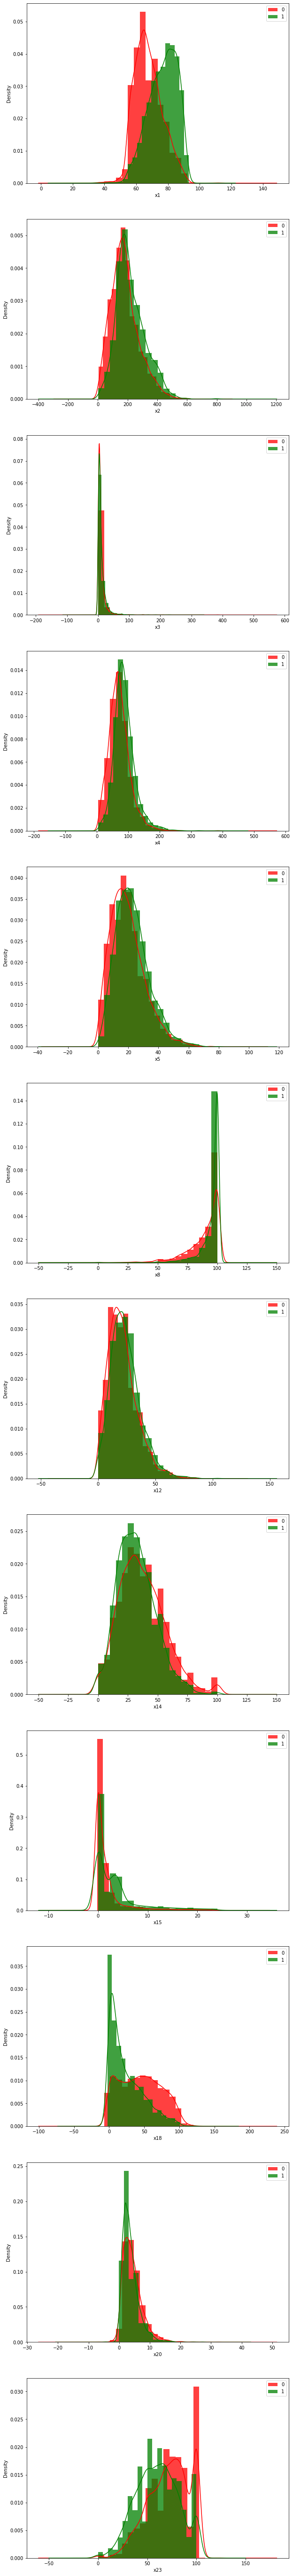

In [0]:
import matplotlib.pyplot as plt

fig, sub = plt.subplots(12, 1,figsize=(10,100))
df_train = df_train_clean
orders = df_train.iloc[:,1:].columns

for ax ,order in zip(sub.flatten(),orders):
    ax.hist(df_train[order][df_train['RiskFlag']==0],bins=20, label='0', density=True, alpha=0.75, color='red')
    ax.hist(df_train[order][df_train['RiskFlag']==1],bins=20, label='1', density=True, alpha=0.75, color='green')
    
    ax.legend(loc="upper right")
    ax.set_xlabel(order)

for i, order in enumerate(orders):
    df_train[order][df_train['RiskFlag']==0].plot(kind='density', color='red', label='', ax=sub[i])
    df_train[order][df_train['RiskFlag']==1].plot(kind='density', color='green', label='', ax=sub[i])
plt.savefig('Distribution.png')
plt.show()

Variable Correlation

There are two groups of variables highly related to each other: (`x2`,`x4`) and (`x12`,`x5`) (correlation > 0.65)

We propose that these 4 variable should not be binned, while we still implemented binning below to check its effect, instead of directly removing these 4.

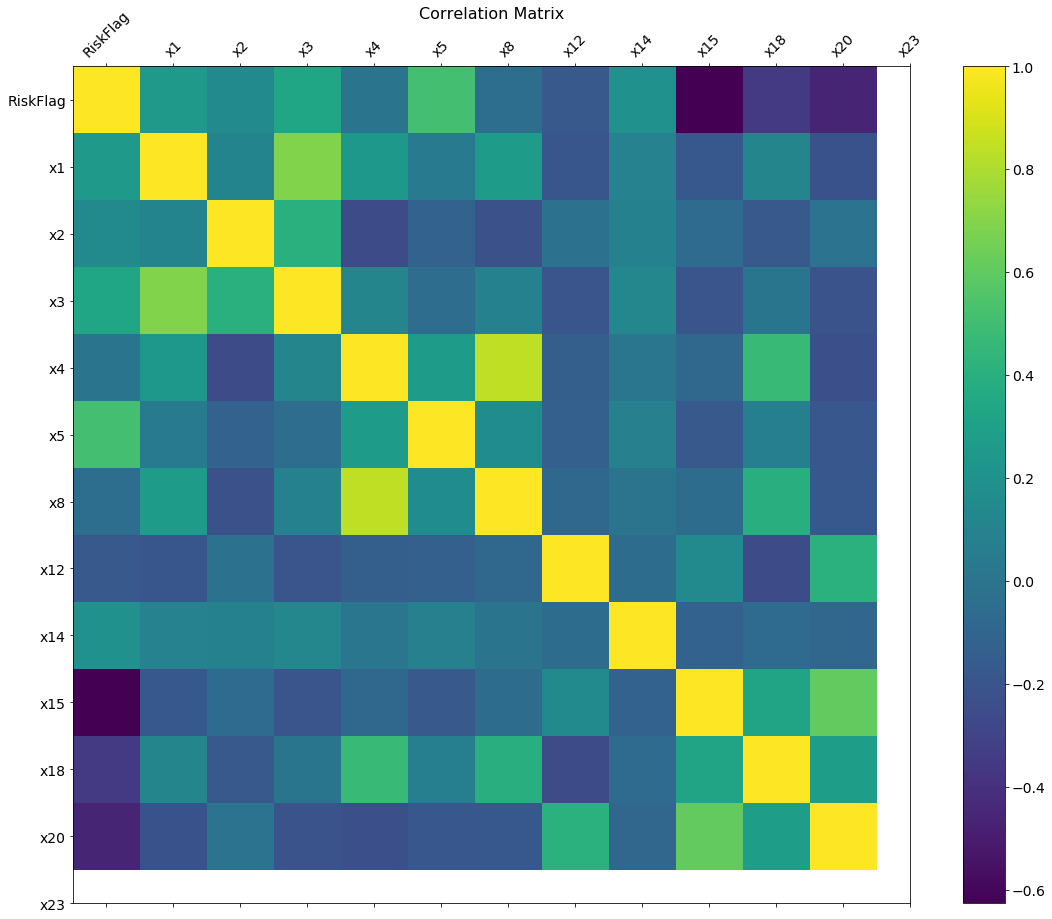

In [0]:
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=45)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Scaling

In [0]:
from sklearn.preprocessing import StandardScaler
fare_scaler = StandardScaler()
for i in ['x3','x8','x20']:
  df_train_clean[i] = fare_scaler.fit_transform(df_train_clean[[i]])
  df_test_clean[i] = fare_scaler.transform(df_test_clean[[i]])


### Piecewise Linear

In [0]:
# Piecewise ReLU, K remain to be decided (Number of output features)
def df_PieceReLU(df, tau=None,set='train'):
    df_tmp = df.copy()
    name=df.name
    if set=='train':
        K = 4
        tau = np.linspace(df_tmp.min(),df_tmp.max(),K+2)[1:-1]
        xphi = df_tmp
        for k in range(len(tau)):
            tmp = [max(x1-tau[k], 0) for x1 in df_tmp]
            xphi = np.column_stack((xphi, tmp))

    xphi = df_tmp
    for k in range(len(tau)):
        tmp = [max(x1-tau[k], 0) for x1 in df_tmp]
        xphi = np.column_stack((xphi, tmp))
        
    df_tmp = pd.DataFrame(xphi)     
    df_tmp.drop(0, axis = 1, inplace = True)
    for i in range(0,df_tmp.shape[1]+1):
        df_tmp = df_tmp.rename(columns={i: name+'_'+str(i)})

    return df_tmp, tau

In [0]:
# Call Piecewise ReLU for a single original variable, take the original variable name(eg.x2), return a dataframe
#for column in df_train_clean.columns: 
#  df_train_PieceReLU, tau= df_PieceReLU(df_train_clean[column], set='train')
#  df_test_PieceReLU= df_PieceReLU(df_test_clean[column],tau, set='test')[0]

# Call Piecewise ReLU for a single original variable, take the original variable name(eg.x2), return a dataframe
df_train_X_PieceReLU_intergrated=pd.DataFrame()
df_test_X_PieceReLU_intergrated=pd.DataFrame()

for column in df_train_clean.columns[1:]:
    df_train_PieceReLU, tau= df_PieceReLU(df_train_clean[column], set='train')
    df_test_PieceReLU= df_PieceReLU(df_test_clean[column],tau, set='test')[0]
    df_train_X_PieceReLU_intergrated = pd.concat([df_train_X_PieceReLU_intergrated,df_train_PieceReLU],axis=1)
    df_test_X_PieceReLU_intergrated = pd.concat([df_test_X_PieceReLU_intergrated,df_test_PieceReLU],axis=1)

x_train_PieceReLU = df_train_X_PieceReLU_intergrated.iloc[:,1:].values
x_test_PieceReLU = df_test_X_PieceReLU_intergrated.iloc[:,1:].values

feature_names_PieceReLU=df_train_X_PieceReLU_intergrated.columns[:].values

### B Spline

In [0]:
import itertools

def B_Spline(df):
    df_tmp1 = df.copy()
    df_tmp2 = df.copy()
    from patsy import dmatrix
    for column in df_tmp1.columns[1:]:
        column_bs = dmatrix('bs(x, df=4, degree=2)-1', {'x': df_tmp1[column]}, return_type='dataframe')
        df_tmp2 = pd.concat([df_tmp2, column_bs], axis=1)
        df_tmp2.drop(column, axis=1, inplace=True)
    lst = list(df.columns)[1:]
    lst = list(itertools.chain.from_iterable(itertools.repeat(x+'_', 4) for x in lst))
    lst.insert(0,'RiskFlag')
    df_tmp2.columns = lst
    return df_tmp2

df_train_BSpline = B_Spline(df_train_clean)
df_test_BSpline = B_Spline(df_test_clean)

x_train_BSpline = df_train_BSpline.iloc[:,1:].values
x_test_BSpline = df_test_BSpline.iloc[:,1:].values

feature_names_BSpline=df_train_BSpline.columns[1:].values

### IV Binning

In [31]:
import scorecardpy as sc
from sklearn.preprocessing import OneHotEncoder

def IVBinning(df_train_clean):
  # df_train_clean
  df_train0 = df_train_clean
  df_X_train0 = df_train_clean.iloc[:,1:]
  # obtain IV bins with training set info
  bins = sc.woebin(df_train0, y='RiskFlag', method='tree')

  # bin each column in training set and combine together
  df_X_train1_IV = df_X_train0.copy()
  for _, col_name in enumerate(df_X_train0.columns):
      breaks = bins[col_name]['breaks'].values.astype(np.float)
      breaks = np.insert(breaks,0,-np.inf)
      
      # set `labels=False` to get binned categorical columns encoded as integer values
      df_X_train1_IV[col_name] = pd.cut(df_X_train0[col_name], bins=breaks, right=True, labels=False)


  # similar in testing set
  # wrong if adding: bins = sc.woebin(df_test0, y='RiskFlag', method='tree')
  df_X_test0 = df_test_clean.iloc[:,1:]
  df_X_test1_IV = df_X_test0.copy()
  for _, col_name in enumerate(df_X_test0.columns):
      breaks = bins[col_name]['breaks'].values.astype(np.float)
      breaks = np.insert(breaks,0,-np.inf)
      
      # set `labels=False` to get binned categorical columns encoded as integer values
      df_X_test1_IV[col_name] = pd.cut(df_X_test0[col_name], bins=breaks, right=True, labels=False)
      
  enc = OneHotEncoder(handle_unknown='ignore')
  X_train_encoded = enc.fit_transform(df_X_train1_IV.values)
  X_test_encoded = enc.transform(df_X_test1_IV.values)
  x_train = X_train_encoded
  x_test = X_test_encoded
  feature_names = enc.get_feature_names(df_train_clean.iloc[:,1:].columns)
  return (X_train_encoded,X_test_encoded,feature_names)
  
(x_train_BinAll,x_test_BinAll,feature_names_BinAll) = IVBinning(df_train_clean)

[INFO] creating woe binning ...
Binning on 7896 rows and 13 columns in 00:00:16


### Raw Data
 - No Feature Engineering (Post Imputing, Pre Scaling)

In [0]:
x_train_raw = df_train_clean.iloc[:,1:].values
y_train = df_train_clean.iloc[:,0].values

x_test_raw = df_test_clean.iloc[:,1:].values
y_test = df_test_clean.iloc[:,0].values

feature_names_raw = df_test_clean.columns[1:].values

# Model Fitting

In [33]:
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import plot_partial_dependence as pdp
!pip install pandasql
from pandasql import sqldf

!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance

  Created wheel for pandasql: filename=pandasql-0.7.3-cp36-none-any.whl size=26820 sha256=490b9f375ddc8a0d54e5f580a9a4db587a4e57bc4502cd74eabf44f96a282c41
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql
     |████████████████████████████████| 112kB 4.8MB/s 


Using TensorFlow backend.


Dataset naming
* A: `x_train_PieceReLU`，`x_test_PieceReLU`, `feature_names_PieceReLU`
* B: `x_train_BSpline`，`x_test_BSpline`，`feature_names_BSpline`
* C: `x_train_BinAll`, `x_test_BinAll`, `feature_names_BinAll`
* D: `x_train_raw`, `x_test_raw`, `feature_names_raw`

## Model 1: Generalized Additive Model

### (a) Piecewise ReLU

In [0]:
from pygam import LogisticGAM, s

# build piecewise linear spline
n_splines = 4

k = s(0, n_splines=n_splines, spline_order=1)
for i in range(1,12):
    k += s(i, n_splines=n_splines, spline_order=1)
print(k)

p_spl = LogisticGAM(k)
p_spl.gridsearch(x_train_raw, y_train) 

y_pred_train = p_spl.predict(x_train_raw)
y_pred_test = p_spl.predict(x_test_raw)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11)


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


The Acc on training set: 0.7421
The Acc on testing set: 0.7256


### (b) **B Spline ***

In [41]:
from pygam import LogisticGAM, s

# build piecewise linear spline
n_splines = 4

k = s(0, n_splines=n_splines)
for i in range(1,12):
    k += s(i, n_splines=n_splines)
print(k)

p_spl = LogisticGAM(k)
p_spl.gridsearch(x_train_raw, y_train) 

y_pred_train = p_spl.predict(x_train_raw)
y_pred_test = p_spl.predict(x_test_raw)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11)


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


The Acc on training set: 0.743
The Acc on testing set: 0.7271


### (c) Binning

In [0]:
from sklearn.preprocessing import KBinsDiscretizer
# fit the binner with training set info
# set `encode='ordinal'` instead of 'onehot-dense' to get binned categorical columns encoded as integer values

df_train_tmp = df_train_clean.iloc[:,1:]
df_test_tmp = df_test_clean.iloc[:,1:]

KBD = KBinsDiscretizer(encode='ordinal', strategy='uniform')
KBD.fit(df_train_tmp)

# transform the training and testing sets with fitted binner
df_X_train1_KBD = df_train_tmp.copy()
df_X_train1_KBD[:] = KBD.transform(df_train_tmp)

df_X_test1_KBD = df_test_tmp.copy()
df_X_test1_KBD[:] = KBD.transform(df_test_tmp) 

df_X_train1_KBD.head()

,x1,x2,x3,x4,x5,x8,x12,x14,x15,x18,x20,x23
8601,2.0,1.0,0.0,1.0,0.0,4.0,0.0,1.0,0.0,0.0,1.0,1.0
2897,1.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,1.0,2.0
1156,3.0,2.0,0.0,1.0,1.0,4.0,1.0,2.0,0.0,1.0,1.0,3.0
2920,1.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0
6563,2.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0


In [0]:
from pygam import LogisticGAM,f,s

k = f(0)
for i in range(1,12):
    k += f(i)
print(k)

gam1_KBD = LogisticGAM(k)
gam1_KBD.gridsearch(df_X_train1_KBD.values, y_train)

y_pred_train = gam1_KBD.predict(df_X_train1_KBD.values)
y_pred_test = gam1_KBD.predict(df_X_test1_KBD.values)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

N/A% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10) + f(11)


100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


The Acc on training set: 0.7172
The Acc on testing set: 0.7114


### (d) Raw Data

In [0]:
from pygam import LogisticGAM, s

# build piecewise linear spline
n_splines = 1

k = s(0, n_splines=n_splines, spline_order=0)
for i in range(1,12):
    k += s(i, n_splines=n_splines, spline_order=0)
print(k)

p_spl = LogisticGAM(k)
p_spl.gridsearch(x_train_raw, y_train) 

y_pred_train = p_spl.predict(x_train_raw)
y_pred_test = p_spl.predict(x_test_raw)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

  9% (1 of 11) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:01

s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11)


100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


The Acc on training set: 0.5171
The Acc on testing set: 0.5332


## Model 2: Decision Tree

### (a) Piecewise ReLU

In [0]:
# fit classification tree with depth 3
from sklearn.tree import DecisionTreeClassifier
dt_clf1 = DecisionTreeClassifier(max_depth=3)
dt_clf1.fit(x_train_PieceReLU, y_train)

y_pred_train = dt_clf1.predict(x_train_PieceReLU)
y_pred_test = dt_clf1.predict(x_test_PieceReLU)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

The Acc on training set: 0.712
The Acc on testing set: 0.6967


In [0]:
## Grid Search SCV
from sklearn.model_selection import GridSearchCV
tuned_parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(DecisionTreeClassifier(),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
clf.fit(x_train_PieceReLU, y_train)

# print the best parameters
print('Best Parameters:',clf.best_params_,'\n',
      "Training accuracy for gb_clf:",accuracy_score(y_train, clf.predict(x_train_PieceReLU)).round(4),'\n',
      "Testing accuracy for gb_clf:",accuracy_score(y_test, clf.predict(x_test_PieceReLU)).round(4))

Best Parameters: {'max_depth': 5, 'min_samples_split': 450} 
 Training accuracy for gb_clf: 0.723 
 Testing accuracy for gb_clf: 0.7013


### (b) B Spline

In [0]:
# fit classification tree with depth 3
from sklearn.tree import DecisionTreeClassifier
dt_clf1 = DecisionTreeClassifier(max_depth=3)
dt_clf1.fit(x_train_BSpline, y_train)

y_pred_train = dt_clf1.predict(x_train_BSpline)
y_pred_test = dt_clf1.predict(x_test_BSpline)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

The Acc on training set: 0.7466
The Acc on testing set: 0.6942


In [0]:
## Grid Search SCV
from sklearn.model_selection import GridSearchCV
tuned_parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(DecisionTreeClassifier(),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
clf.fit(x_train_BSpline, y_train)

# print the best parameters
print('Best Parameters:',clf.best_params_,'\n',
      "Training accuracy for gb_clf:",accuracy_score(y_train, clf.predict(x_train_BSpline)).round(4),'\n',
      "Testing accuracy for gb_clf:",accuracy_score(y_test, clf.predict(x_test_BSpline)).round(4))

Best Parameters: {'max_depth': 5, 'min_samples_split': 230} 
 Training accuracy for gb_clf: 0.757 
 Testing accuracy for gb_clf: 0.6992


### (c) IV Binning

In [0]:
# fit classification tree with depth 3
from sklearn.tree import DecisionTreeClassifier
dt_clf1 = DecisionTreeClassifier(max_depth=3)
dt_clf1.fit(x_train_BinAll, y_train)

y_pred_train = dt_clf1.predict(x_train_BinAll)
y_pred_test = dt_clf1.predict(x_test_BinAll)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

The Acc on training set: 0.7225
The Acc on testing set: 0.7266


In [0]:
## Grid Search SCV
from sklearn.model_selection import GridSearchCV
tuned_parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(DecisionTreeClassifier(),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
clf.fit(x_train_BinAll, y_train)

# print the best parameters
print('Best Parameters:',clf.best_params_,'\n',
      "Training accuracy for gb_clf:",accuracy_score(y_train, clf.predict(x_train_BinAll)).round(4),'\n',
      "Testing accuracy for gb_clf:",accuracy_score(y_test, clf.predict(x_test_BinAll)).round(4))

Best Parameters: {'max_depth': 13, 'min_samples_split': 150} 
 Training accuracy for gb_clf: 0.759 
 Testing accuracy for gb_clf: 0.7382


### (d) **Raw Data ***

In [0]:
# fit classification tree with depth 3
from sklearn.tree import DecisionTreeClassifier
dt_clf1 = DecisionTreeClassifier(max_depth=3)
dt_clf1.fit(x_train_raw, y_train)

y_pred_train = dt_clf1.predict(x_train_raw)
y_pred_test = dt_clf1.predict(x_test_raw)

print('The Acc on training set:',accuracy_score(y_train,y_pred_train).round(4))
print('The Acc on testing set:',accuracy_score(y_test,y_pred_test).round(4))

The Acc on training set: 0.747
The Acc on testing set: 0.7357


In [0]:
## Grid Search SCV
from sklearn.model_selection import GridSearchCV
tuned_parameters={'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2)}
clf=GridSearchCV(DecisionTreeClassifier(),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
clf.fit(x_train_raw, y_train)

# print the best parameters
print('Best Parameters:',clf.best_params_,'\n',
      "Training accuracy for gb_clf:",accuracy_score(y_train, clf.predict(x_train_raw)).round(4),'\n',
      "Testing accuracy for gb_clf:",accuracy_score(y_test, clf.predict(x_test_raw)).round(4))

Best Parameters: {'max_depth': 7, 'min_samples_split': 170} 
 Training accuracy for gb_clf: 0.7812 
 Testing accuracy for gb_clf: 0.7524


## Model 3: GradientBoostingClassifier

In [0]:
#Fit the gradient boosting machines

def PrintGBAcc(X_train,X_test,y_train,y_test,feature_engineer):
  from sklearn.svm import SVC
  from sklearn.svm import LinearSVC
  gb_clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=60)
  gb_clf.fit(X_train, y_train)
  gb_pred_train= gb_clf.predict(X_train)
  gb_pred_test= gb_clf.predict(X_test)
  print('Training accuracy for the gradient boosting machines is',feature_engineer,':', accuracy_score(y_train, gb_pred_train).round(4))
  print('Testing accuracy for the gradient boosting machines is',feature_engineer,':', accuracy_score(y_test, gb_pred_test).round(4))

PrintGBAcc(x_train_PieceReLU,x_test_PieceReLU,y_train,y_test,'PieceReLU')
PrintGBAcc(x_train_BSpline,x_test_BSpline,y_train,y_test,'BSpline')
PrintGBAcc(x_train_BinAll,x_test_BinAll,y_train,y_test,'IV Binning')
PrintGBAcc(x_train_raw,x_test_raw,y_train,y_test,'Raw Data')

Training accuracy for the gradient boosting machines is PieceReLU : 0.7794
Testing accuracy for the gradient boosting machines is PieceReLU : 0.7028
Training accuracy for the gradient boosting machines is BSpline : 0.8356
Testing accuracy for the gradient boosting machines is BSpline : 0.7195
Training accuracy for the gradient boosting machines is IV Binning : 0.7938
Testing accuracy for the gradient boosting machines is IV Binning : 0.7549
Training accuracy for the gradient boosting machines is Raw Data : 0.8294
Testing accuracy for the gradient boosting machines is Raw Data : 0.7742


In [0]:
## Random Search SCV

from sklearn.model_selection import RandomizedSearchCV
# RandomizedSearchCV automatically returns the best model.

# Hyper-parameter space.
tuned_parameters = { 'max_depth': np.arange(4,9,1),'learning_rate': uniform(loc=0.08,scale=0.04),'n_estimators': np.arange(50,100,10)
                      }

clf = RandomizedSearchCV(GradientBoostingClassifier(), tuned_parameters,scoring='accuracy',cv=5,n_iter=50)
clf.fit(x_train_raw, y_train)
# print the best parameters
print('Best Parameters:',clf.best_params_,'\n',
      "Training accuracy for gb_clf:",accuracy_score(y_train, clf.predict(x_train_raw)).round(4),'\n',
      "Testing accuracy for gb_clf:",accuracy_score(y_test, clf.predict(x_test_raw)).round(4))

Best Parameters: {'learning_rate': 0.09981653591378371, 'max_depth': 5, 'n_estimators': 90} 
 Training accuracy for gb_clf: 0.8451 
 Testing accuracy for gb_clf: 0.7742


## Model 4: Supported Vector Machine
LinearSVC and SVC-rbf

In [34]:
## Benchmark ACC. 0.7362 (Linear SVM)

def PrintSVCAcc(X_train,X_test,y_train,y_test,feature_engineer):
  from sklearn.svm import SVC
  from sklearn.svm import LinearSVC

  # fit the linear kernel model
  linSVC = LinearSVC(max_iter=10000)
  linSVC.fit(X_train,y_train)
  # show accuracy 
  print('Linear SVM Accuracy',feature_engineer,':',accuracy_score(y_test,linSVC.predict(X_test)).round(4))

  # fit the model with RBF kernel
  rbfSVC = SVC(degree=3,C=7,kernel='rbf')
  rbfSVC.fit(X_train,y_train)
  # show accuracy 
  print('RBF SVM Accuracy',feature_engineer,':',accuracy_score(y_test,rbfSVC.predict(X_test)).round(4))

PrintSVCAcc(x_train_PieceReLU,x_test_PieceReLU,y_train,y_test,'PieceReLU')
PrintSVCAcc(x_train_BSpline,x_test_BSpline,y_train,y_test,'BSpline')
PrintSVCAcc(x_train_BinAll,x_test_BinAll,y_train,y_test,'IV Binning')
PrintSVCAcc(x_train_raw,x_test_raw,y_train,y_test,'Raw Data')

Linear SVM Accuracy PieceReLU : 0.6208
RBF SVM Accuracy PieceReLU : 0.5894
Linear SVM Accuracy BSpline : 0.718
RBF SVM Accuracy BSpline : 0.7119
Linear SVM Accuracy IV Binning : 0.7387
RBF SVM Accuracy IV Binning : 0.7423
Linear SVM Accuracy Raw Data : 0.6916
RBF SVM Accuracy Raw Data : 0.5342


In [0]:
## Random Search RBF SCV

from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

## RandomSearch RBF
def PrintRandomSearchRBF(X_train,X_test,y_train,y_test,feature_engineering):
  tuned_parameters = {'kernel': ['rbf'],
                      'C': uniform(loc=3,scale=5),
                      'degree': [3]}
  clf = RandomizedSearchCV(SVC(), tuned_parameters, cv=5,n_iter=10,scoring='accuracy')
  clf.fit(X_train, y_train)
  # print the best parameters
  print('RBF - Best Parameters',feature_engineering,':',clf.best_params_,'\n',
        'RBF - Training accuracy',feature_engineering,':',accuracy_score(y_train, clf.predict(X_train)).round(4),'\n',
        'RBF - Testing accuracy for gb_clf',feature_engineering,':',accuracy_score(y_test, clf.predict(X_test)).round(4))

PrintRandomSearchRBF(x_train_BSpline ,x_test_BSpline ,y_train,y_test,'BSpline')

print('\n')

## Random Search LinearSVC
def PrintRandomSearchLinearSVC(X_train,X_test,y_train,y_test,feature_engineering):
  tuned_parameters = {'C': uniform(loc=3,scale=5),
                      'max_iter': uniform(loc=10000,scale=50000)}
  clf = RandomizedSearchCV(LinearSVC(), tuned_parameters, cv=5,n_iter=10,scoring='accuracy')
  clf.fit(X_train, y_train)
  # print the best parameters
  print('LinearSVC - Best Parameters',feature_engineering,':',clf.best_params_,'\n',
        'LinearSVC - Training accuracy',feature_engineering,':',accuracy_score(y_train, clf.predict(X_train)).round(4),'\n',
        'LinearSVC - Testing accuracy for gb_clf',feature_engineering,':',accuracy_score(y_test, clf.predict(X_test)).round(4))
PrintRandomSearchLinearSVC(x_train_BSpline ,x_test_BSpline ,y_train,y_test,'BSpline')

RBF - Best Parameters BSpline : {'C': 5.492484455047691, 'degree': 3, 'kernel': 'rbf'} 
 RBF - Training accuracy BSpline : 0.7397 
 RBF - Testing accuracy for gb_clf BSpline : 0.7144


LinearSVC - Best Parameters BSpline : {'C': 7.824124490611895, 'max_iter': 54158.235945119704} 
 LinearSVC - Training accuracy BSpline : 0.7409 
 LinearSVC - Testing accuracy for gb_clf BSpline : 0.7154


## Model 5: Neural Network

### (a) Piecewise ReLU

In [0]:
# Hyper-parameter space.
tuned_parameters = {'solver': ['adam'],'alpha': 10.0 ** -np.arange(-4, 4,4), 'hidden_layer_sizes':np.arange(150, 300,50), 'random_state':[0,1,2,3]

                    #,'colsample_bytree' : [0.3], 'learning_rate' : [0.1,0.3,0.07]
                    #,'max_depth' : [5], 'alpha' : [10], 'n_estimators' : [20]
                    #,'monotone_constraints':[(1,-1)]
                }

# GridSearchCV automatically returns the best model.
MLP_PieceReLU = RandomizedSearchCV(MLPClassifier(max_iter=1000), tuned_parameters, cv=5,n_iter=10,
                       scoring='accuracy',random_state=2019)
MLP_PieceReLU.fit(x_train_PieceReLU, y_train)

feature_names=feature_names_PieceReLU
# print the best parameters
print('Training accuracy for the MLPClassifier with Piecewise ReLU feature engineering is:', accuracy_score(y_train,MLP_PieceReLU.predict(x_train_PieceReLU)).round(4))
print('Testing accuracy for the MLPClassifier with Piecewise ReLU feature engineering is:', accuracy_score(y_test,MLP_PieceReLU.predict(x_test_PieceReLU)).round(4))
MLP_PieceReLU

### (b) B Spline

In [0]:
## GridSearch SCV

# Hyper-parameter space.
tuned_parameters = {'solver': ['adam'],'alpha': 10.0 ** -np.arange(-4, 4,4), 'hidden_layer_sizes':np.arange(150, 300,50), 'random_state':[0,1,2,3]

                    #,'colsample_bytree' : [0.3], 'learning_rate' : [0.1,0.3,0.07]
                    #,'max_depth' : [5], 'alpha' : [10], 'n_estimators' : [20]
                    #,'monotone_constraints':[(1,-1)]
                }


# GridSearchCV automatically returns the best model.
MLP_BSpline = GridSearchCV(MLPClassifier(max_iter=1000),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
MLP_BSpline.fit(x_train_BSpline, y_train)

#feature_names=feature_name_BSpline
# print the best parameters
print('Training accuracy for the MLPClassifier with BSpline feature engineering is:', accuracy_score(y_train,MLP_BSpline.predict(x_train_BSpline)).round(4))
print('Testing accuracy for the MLPClassifier with BSpline feature engineering is:', accuracy_score(y_test,MLP_BSpline.predict(x_test_BSpline)).round(4))
MLP_BSpline

### (c) **IV Binning***

In [0]:
## GridSearch SCV
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
# Hyper-parameter space.
tuned_parameters = {'solver': ['adam'],'alpha': 10.0 ** -np.arange(-4, 4,4), 'hidden_layer_sizes':np.arange(150, 250,50)

                    #,'colsample_bytree' : [0.3], 'learning_rate' : [0.1,0.3,0.07]
                    #,'max_depth' : [5], 'alpha' : [10], 'n_estimators' : [20]
                    #,'monotone_constraints':[(1,-1)]
                }


# GridSearchCV automatically returns the best model.
MLP_BinAll = GridSearchCV(MLPClassifier(max_iter=1000),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
MLP_BinAll.fit(x_train_BinAll, y_train)

#feature_names=feature_names_BinAll
# print the best parameters
print('Training accuracy for the MLPClassifier with BinAll feature engineering is:', accuracy_score(y_train,MLP_BinAll.predict(x_train_BinAll)).round(4))
print('Testing accuracy for the MLPClassifier with BinAll feature engineering is:', accuracy_score(y_test,MLP_BinAll.predict(x_test_BinAll)).round(4))
MLP_BinAll

Training accuracy for the MLPClassifier with BinAll feature engineering is: 0.7601
Testing accuracy for the MLPClassifier with BinAll feature engineering is: 0.7448


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=1000,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'alpha': array([1.e+04, 1.e+00]),
      

### (d) Raw Data 

In [0]:
## GridSearch SCV

# Hyper-parameter space.
tuned_parameters = {'solver': ['adam'],'alpha': 10.0 ** -np.arange(-4, 4,4), 'hidden_layer_sizes':np.arange(150, 300,50), 'random_state':[0,1,2,3]

                    #,'colsample_bytree' : [0.3], 'learning_rate' : [0.1,0.3,0.07]
                    #,'max_depth' : [5], 'alpha' : [10], 'n_estimators' : [20]
                    #,'monotone_constraints':[(1,-1)]
                }


# GridSearchCV automatically returns the best model.
MLP_Raw = GridSearchCV(MLPClassifier(max_iter=1000),tuned_parameters,scoring='accuracy',cv=5,return_train_score=True)
MLP_Raw.fit(x_train_raw, y_train)

#feature_names=feature_names_raw
# print the best parameters
print('Training accuracy for the MLPClassifier with Raw data is:', accuracy_score(y_train,MLP_Raw.predict(x_train_raw)).round(4))
print('Testing accuracy for the MLPClassifier with Raw data is:', accuracy_score(y_test,MLP_Raw.predict(x_test_raw)).round(4))
MLP_Raw

# Interpretation

## MLP + IV Binning

In [37]:
!pip install shap 
import shap
shap.initjs()

     |████████████████████████████████| 266kB 4.9MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382249 sha256=a619de06b55a5275d81b9a3924cc27a343d5dc699e345d7ef73e9505946821cf
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


[[ 0.02766379  0.07155907  0.00414827 ...  0.          0.
  -0.00976765]
 [-0.10159977  0.          0.         ...  0.          0.
   0.        ]
 [ 0.02804328  0.05613811  0.         ...  0.          0.
   0.        ]
 ...
 [ 0.01818077  0.04751158  0.         ...  0.00293037  0.00964545
   0.        ]
 [-0.08718068  0.         -0.00215513 ...  0.         -0.00429145
   0.        ]
 [ 0.01060109  0.0271138   0.         ... -0.00917211 -0.01509653
   0.        ]]
[0.22987334129610987, 0.013164123275038993, -0.01146878512703069, 0.11688258820674682, 0.010057942737071966, -0.010431549677799766, 0.004258376168904954, 0.03229543200506745, -0.030544243781928722, 0.156735954908815, 0.0711730100018936, -0.04199619001288957]
[-0.1338062988686591, -0.03598746000136449, 0.0, -0.08999974099040306, -0.047199527462381374, -0.04663817933347553, 0.0, 0.02512771932618532, -0.12540322163037207, -0.0060932910395298245, 0.0, 0.0]
[0.27001733777366116, 0.060765467765020106, 0.0, 0.11983118658127043, 0.011

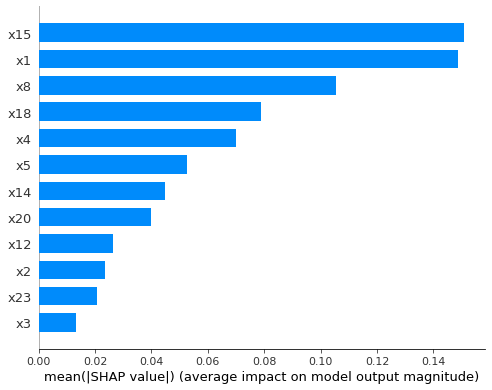

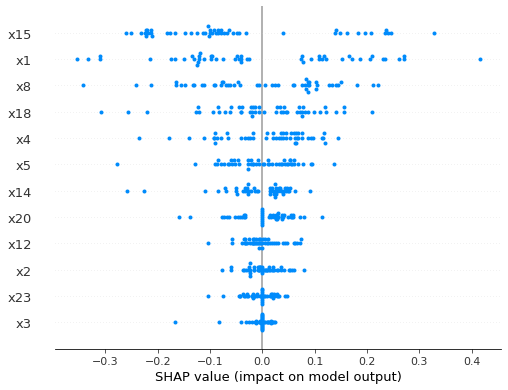

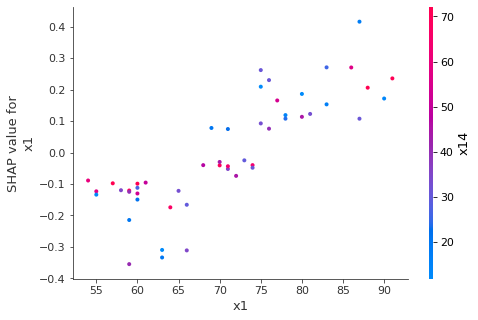

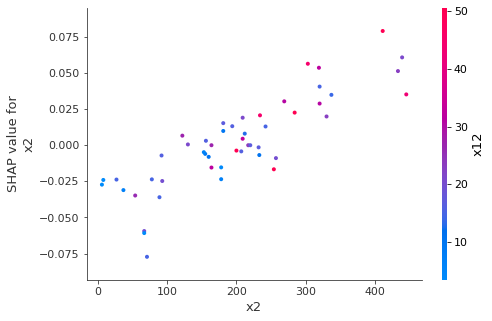

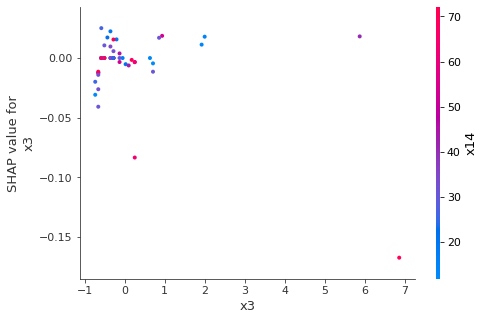

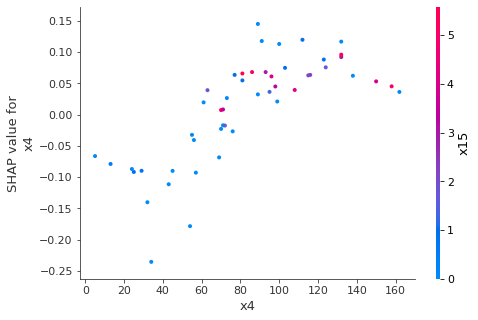

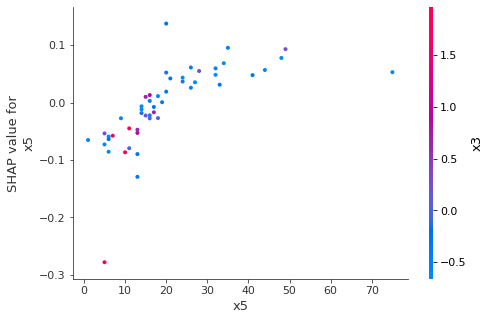

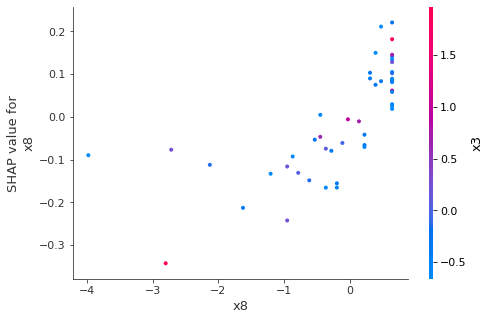

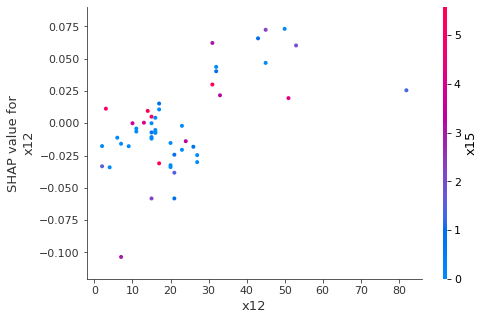

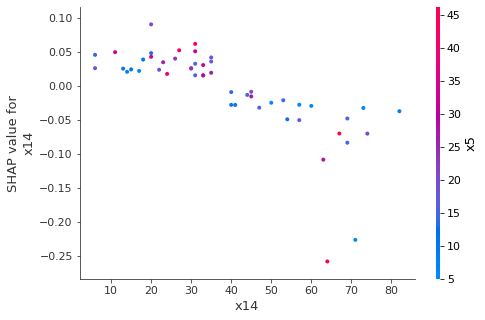

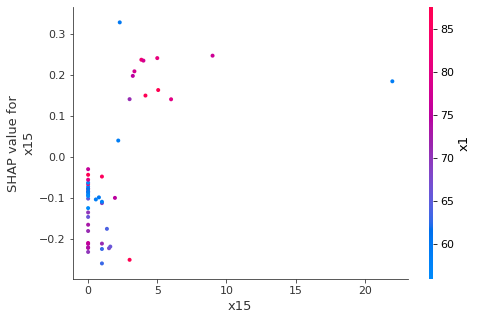

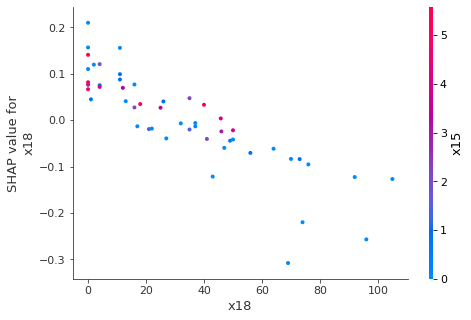

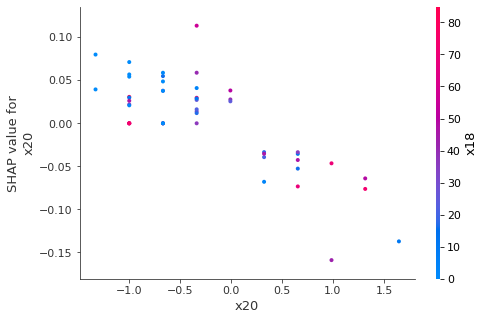

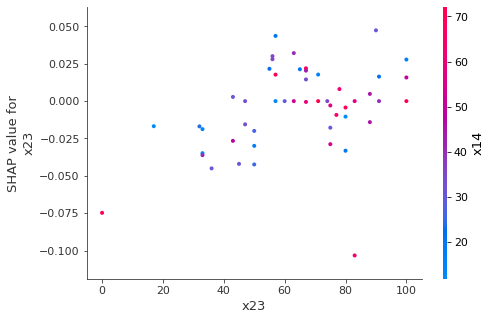

In [0]:
def IntergrateSHAP(feature_names,feature_names_raw,shap_range,shap_values):
  feature_list = list(feature_names).copy()
  shap_integrated_all=[]
  for i in range(shap_range):
    shap_integrated=[]
    for column in feature_names_raw:
        shap_integrating = 0
        for feature_name in feature_names:
            if feature_name.startswith(column+'_'):
                feature_index = feature_list.index(feature_name)
                shap_integrating = shap_integrating + shap_values[i][feature_index]
        shap_integrated.append(shap_integrating)
    print(shap_integrated)
    shap_integrated_all.append(shap_integrated)
  return shap_integrated_all

def PlotSHAP(MLP_BinAll,x_train_BinAll,feature_names_BinAll,x_train_raw,feature_names_raw,shap_range):
  # define the explainer
  explainer = shap.KernelExplainer(MLP_BinAll.predict,shap.sample(x_train_BinAll, 50))
  # calculate the shape value on training data
  # set approximate=True for fast processing
  shap_values = explainer.shap_values(x_train_BinAll[:shap_range], approximate=True)
  print(shap_values)
  

  ## shap_values_int = shap values after integration, it is a np.array with shape: (shap_range,12)
  ## feature_names = np.array(['x1','x2',...,'x23'])
  shap_values_int=np.array(IntergrateSHAP(feature_names_BinAll,feature_names_raw,shap_range,shap_values))
  feature_names=feature_names_raw

  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names, plot_type='bar')
  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names)
  
  # plot pdp
  for column in feature_names_raw:
    shap.dependence_plot(column, shap_values_int, x_train_raw[:shap_range], feature_names=feature_names)
  
  return (shap_values_int,feature_names)

(shap_values_int,feature_names) = PlotSHAP(MLP_BinAll,x_train_BinAll,feature_names_BinAll,x_train_raw,feature_names_raw,50)

In [0]:
# force_plot for one trainning data X_i
shap.initjs()
i=1
shap.force_plot(explainer.expected_value, shap_values_int[i], x_train_raw[i], feature_names=feature_names)

In [0]:
# force_plot for all trainning data
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values_int), x_train_raw, feature_names=feature_names)

**MLP Global interpretation**

It can be conclude from the above graphs that the importance gap between features for this Multi-layer perceptron (MLP) classifier model are not dramatically large. All variables except `x2(Months Since Oldest Trade Open)`, `x3(Months Since Most Recent Trade Open)`, `x12(Number of Total Trades (total number of credit accounts))`, `x23(Percent Trades with Balance)` impact the model’s prediction output considerably, especially for `x15(Months Since Most Recent Inq excl 7days)` and `x1(Consolidated version of risk markers)`. 

From the partial dependence plots, we found that variable `x1(Consolidated version of risk markers)`, `x4(Average Months in File)`, `x5(Number Satisfactory Trades)` and `x8(Percent Trades Never Delinquent)` are positively correlated with the probability of being marked as good for Risk Flag, while `x14(Percent Installment Trades)`, `x18(Revolving balance divided by credit limit)` and `x20(Number Revolving Trades with Balance)` are negatively correlated with the probability of being marked as good for Risk Flag, which agrees with our intuition and prior knowledge. 

---

**MLP Local interpretation**

We are interested in how each feature pushes the sample prediction from the SHAP base value to the final result. The above graph visualized the effects of the second sample (sample index=1) in the training dataset. The prediction result for the first sample is -0.26, indicating a high likelihood to loan default. Starting from the base value 0.2, the predicted SHAP value mainly driven towards the negative outcome (Bad) by factors including `x1(Consolidated version of risk markers)`, `x15(Months Since Most Recent Inq excl 7days)` and `x4(Average Months in File)`. It can be interpreted as the customer has is likely to default on the loan for his/her short history in file, and relatively low score in the consolidated risk markers.

## GB + Raw

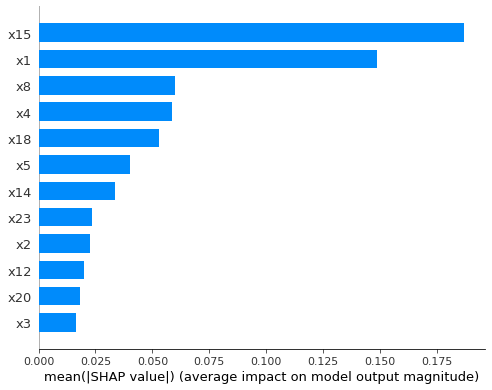

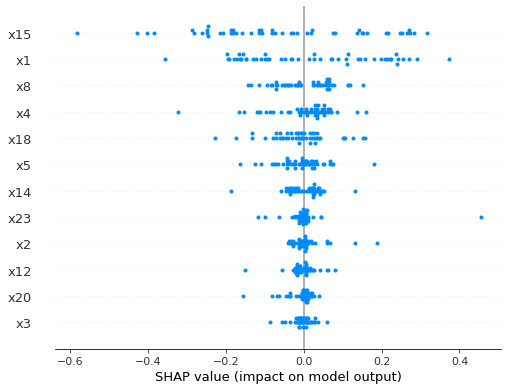

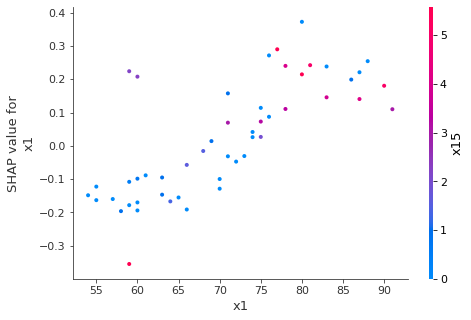

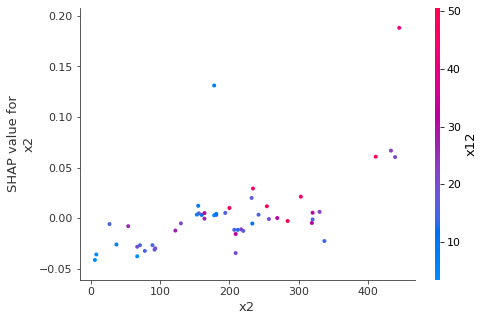

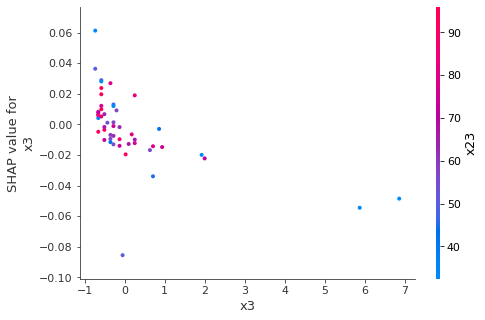

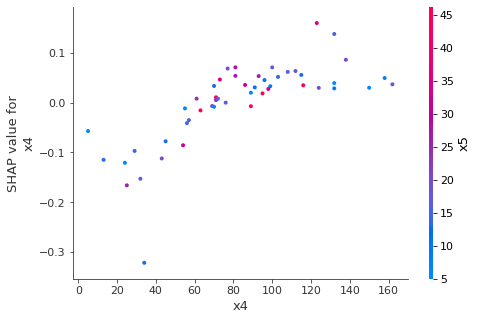

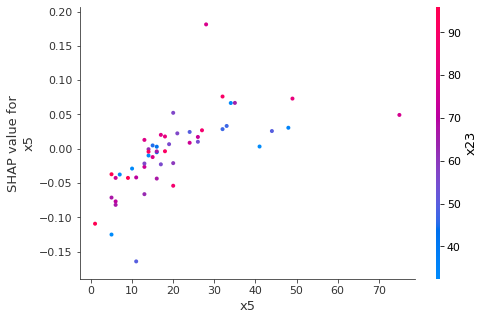

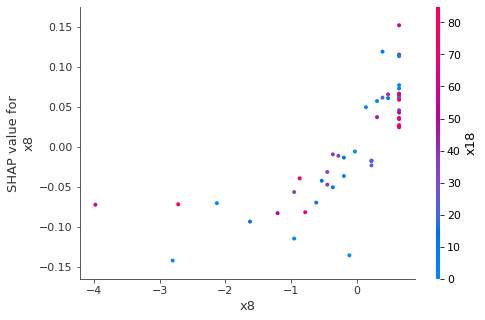

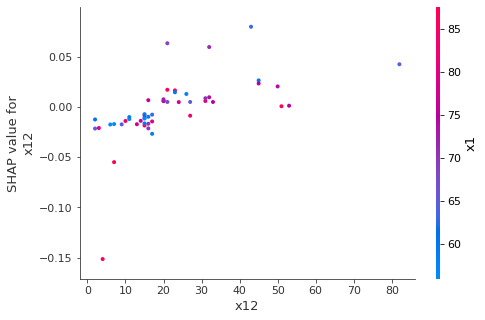

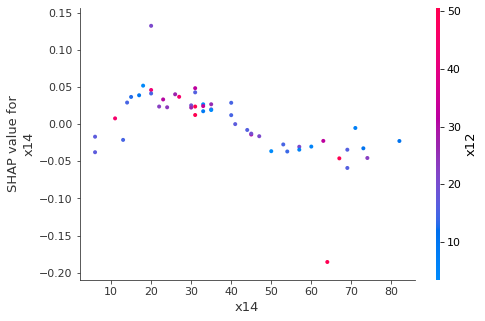

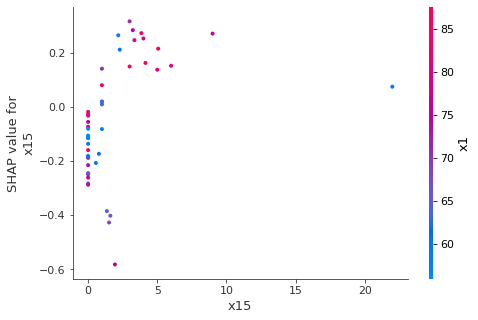

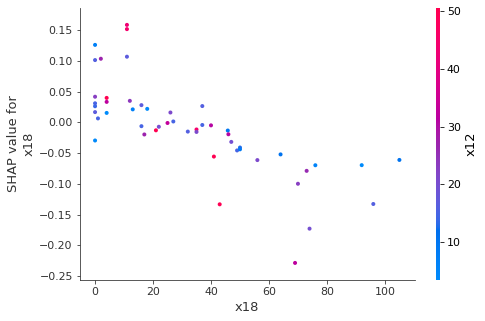

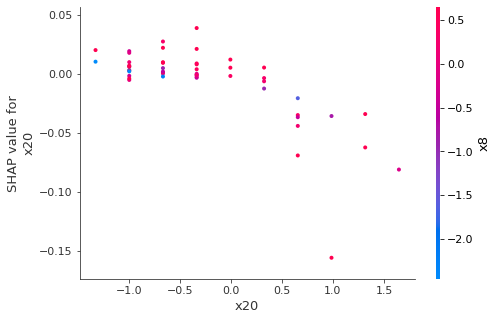

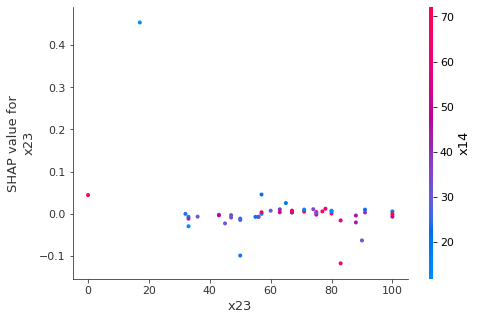

In [0]:
shap_range = 50
clf = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=60)
clf.fit(x_train_raw, y_train)
# define the explainer
explainer = shap.KernelExplainer(clf.predict,shap.sample(x_train_raw, 50))
# calculate the shape value on training data
# set approximate=True for fast processing
shap_values_int = explainer.shap_values(x_train_raw[:shap_range], approximate=True)

shap.summary_plot(np.array(shap_values_int), feature_names=feature_names_raw, plot_type='bar')
shap.summary_plot(np.array(shap_values_int), feature_names=feature_names_raw)

# plot pdp
for column in feature_names_raw:
  shap.dependence_plot(column, shap_values_int, x_train_raw[:shap_range], feature_names=feature_names_raw)

In [0]:
# force_plot for one trainning data X_i
shap.initjs()
i=1
shap.force_plot(explainer.expected_value, shap_values_int[i], x_train_raw[i], feature_names=feature_names)

In [0]:
# force_plot for all trainning data
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values_int), x_train_raw, feature_names=feature_names)

Our Gradient Boosting Classifier with learning_rate=0.1, max_depth=5, n_estimators=60 yield a test accuracy to 77.42%. This overwhelming accuracy makes us more intrigued to know about what is happening in this black box model. We use KernelExplainer to interpret the model. From the mean value of absolution SHAP, we know `x15`,`x1`,`x8`,`x4`,`x18` have a strong effect when estimating y, which agrees with the result in MLP SHAP.

---

From the PDP graph of `x15`, we know once `x15` is lower than about 2.5, the SHAP values tend to be negative, which means the model dislikes `x15`. Practically, once someone’s Months Since Most Recent Inquiry is too low than a threshold, it is likely that there will be bad debt. This means if you ask too frequent, it is likely to be a ‘Bad’ RiskFlag.

From the PDP graph of `x1`, we know the higher the x1, the response is more likely to be a ‘Good’ one. Empirically, the higher the consolidated version of risk markers, the safer a loan is.

From the PDP graph of `x8`, SHAP value tends to increase as `x8` value increases. The watershed effect also prevails. If the Percent of Trades Never Delinquent is high enough, then it is much more likely to be a ‘Good’ RiskFlag.

The PDP graph of `x4` shows that more data is shown to locate around SHAP value = 0 compared to the above three plots. But the relationship is prominently positive. Practically, the higher someone’s Average Months in File is recorded, the higher chance he is going to be marked ‘Good’. While for most people the model doesn’t think their months in file matter.

The PDP graph of `x18` suggests while most data has SHAP value = 0, data in the highest 20% quantile of `x18` tends to push its SHAP value extreme lower. It indicates once someone has a too high Net Fraction Revolving Burden, it is much more likely that he will be marked ‘Bad’.

## SVM (rbf) + IV Binning


[[ 0.03723357  0.06378685  0.03622663  0.27383726  0.          0.0078161
   0.          0.          0.00747226  0.          0.00496799 -0.01451011
  -0.01679008  0.          0.          0.          0.          0.02090039
   0.          0.          0.          0.00445398 -0.02742318  0.04314508
   0.00456622  0.02645661 -0.04122028  0.01032649  0.          0.00613195
   0.          0.          0.01717513  0.          0.          0.
  -0.03396465  0.03099737 -0.02698852  0.00546168  0.09320201 -0.0164253
   0.          0.00900196  0.00450333  0.01316492  0.          0.
   0.00760694  0.00888743  0.          0.        ]
 [-0.13306982  0.          0.         -0.04531444 -0.03482501 -0.02520238
  -0.00480847  0.         -0.00517977  0.          0.         -0.006692
   0.          0.         -0.03075567 -0.00168719  0.         -0.00907077
   0.         -0.01545563  0.          0.         -0.01513891  0.
  -0.0012416   0.         -0.03204814  0.          0.          0.
   0.          0.     

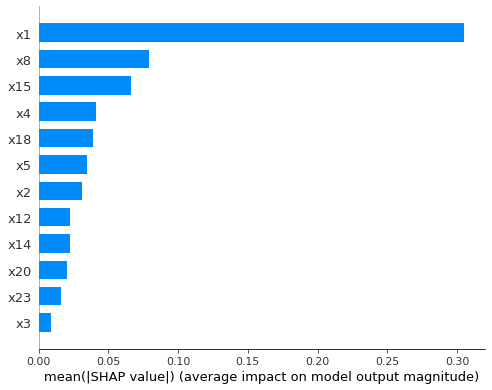

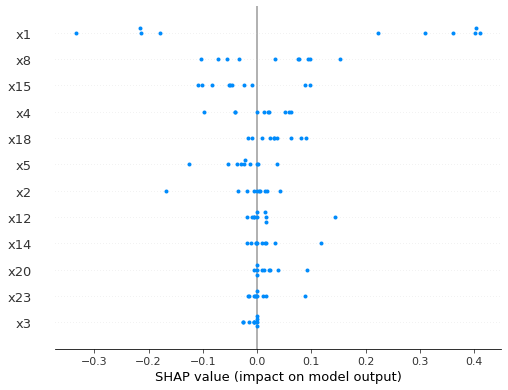

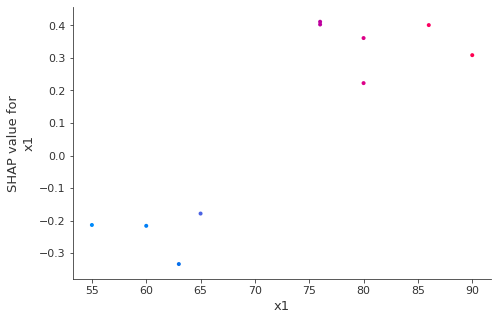

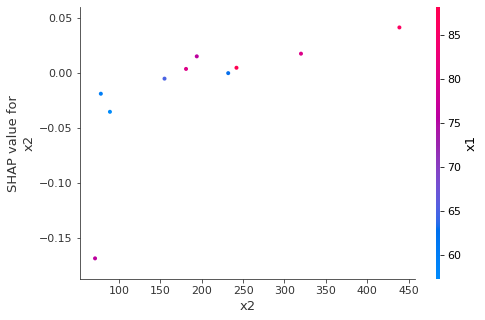

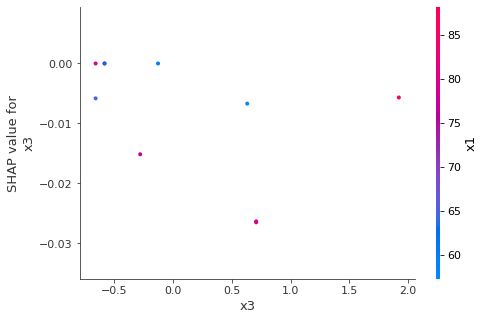

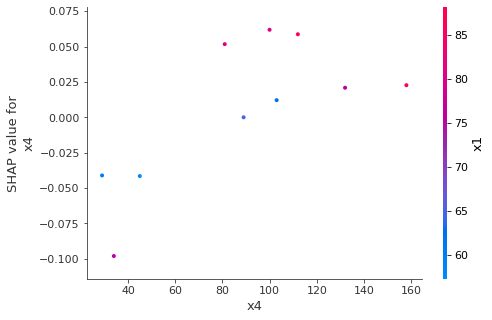

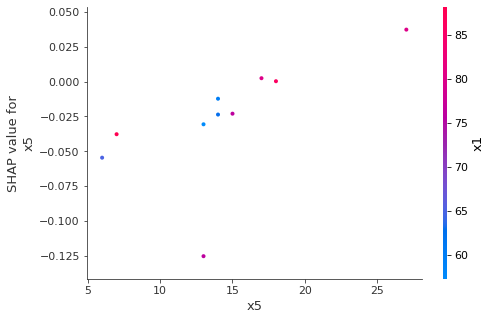

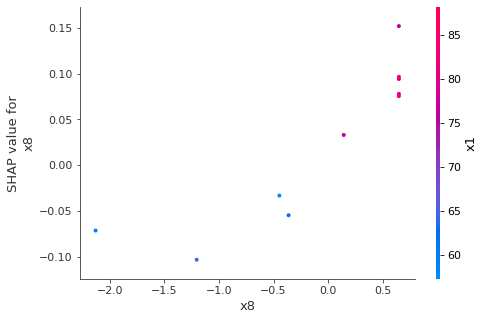

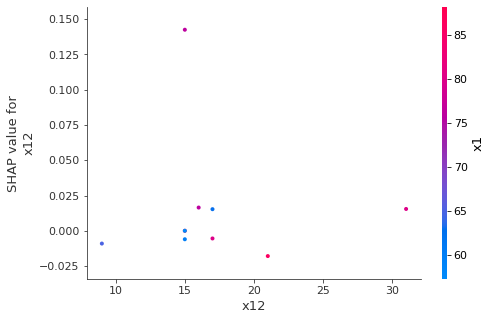

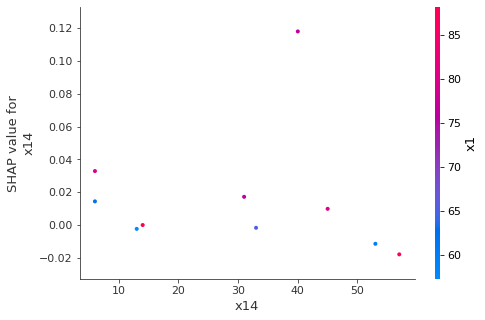

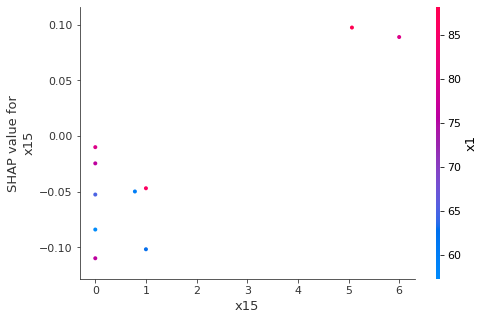

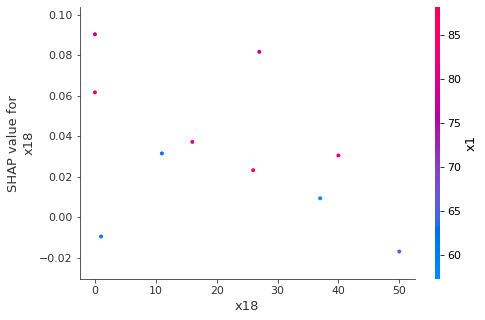

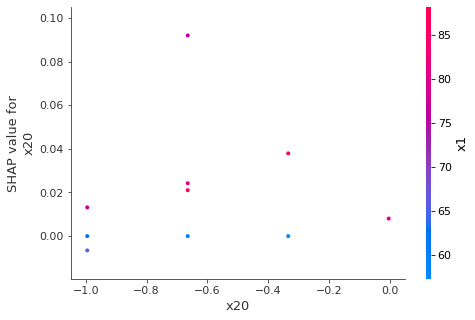

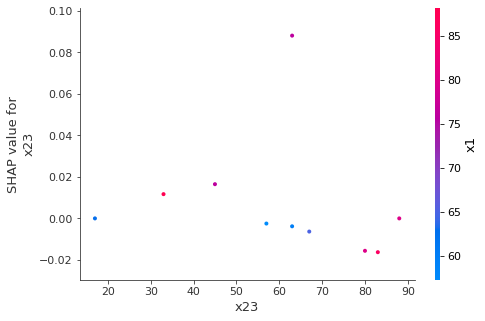

In [38]:
def IntergrateSHAP(feature_names,feature_names_raw,shap_range,shap_values):
  feature_list = list(feature_names).copy()
  shap_integrated_all=[]
  for i in range(shap_range):
    shap_integrated=[]
    for column in feature_names_raw:
        shap_integrating = 0
        for feature_name in feature_names:
            if feature_name.startswith(column+'_'):
                feature_index = feature_list.index(feature_name)
                shap_integrating = shap_integrating + shap_values[i][feature_index]
        shap_integrated.append(shap_integrating)
    print(shap_integrated)
    shap_integrated_all.append(shap_integrated)
  return shap_integrated_all

def PlotSHAP(MLP_BinAll,x_train_BinAll,feature_names_BinAll,x_train_raw,feature_names_raw,shap_range):
  # define the explainer
  explainer = shap.KernelExplainer(MLP_BinAll.predict,shap.sample(x_train_BinAll, 50))
  # calculate the shape value on training data
  # set approximate=True for fast processing
  shap_values = explainer.shap_values(x_train_BinAll[:shap_range], approximate=True)
  print(shap_values)
  

  ## shap_values_int = shap values after integration, it is a np.array with shape: (shap_range,12)
  ## feature_names = np.array(['x1','x2',...,'x23'])
  shap_values_int=np.array(IntergrateSHAP(feature_names_BinAll,feature_names_raw,shap_range,shap_values))
  feature_names=feature_names_raw

  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names, plot_type='bar')
  shap.summary_plot(np.array(shap_values_int), feature_names=feature_names)
  
  # plot pdp
  for column in feature_names_raw:
    shap.dependence_plot(column, shap_values_int, x_train_raw[:shap_range], feature_names=feature_names)
  
  return (shap_values_int,feature_names)


clf = SVC(degree=3,C=7,kernel='rbf')
clf.fit(x_train_BinAll,y_train)
(shap_values_int,feature_names) = PlotSHAP(clf,x_train_BinAll,feature_names_BinAll,x_train_raw,feature_names_raw,10)

In [39]:
# force_plot for one trainning data X_i
shap.initjs()
i=1
shap.force_plot(explainer.expected_value, shap_values_int[i], x_train_raw[i], feature_names=feature_names)

NameError: ignored

In [0]:
# force_plot for all trainning data
shap.initjs()
shap.force_plot(explainer.expected_value, np.array(shap_values_int), x_train_raw, feature_names=feature_names)

## Decision Tree + Raw

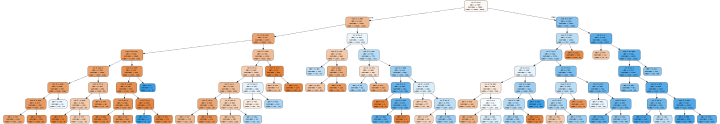

In [0]:
from sklearn import tree
import pydotplus
import graphviz

clf.best_estimator_.fit(x_train_raw, y_train)

feature_names_raw = df_test_clean.columns[1:].values

dot_data = tree.export_graphviz(clf.best_estimator_, out_file=None,
                                   feature_names=feature_names_raw,
                                   filled=True, rounded=True,
                                   special_characters=True) 

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.set_size('"10,7!"')
gvz_graph = graphviz.Source(pydot_graph.to_string())
gvz_graph

***Decision Tree Interpretation***

The fitted decision tree model firstly cut at `x1(Consolidated version of risk markers)` at 73.5 and then at `x15(Months Since Most Recent Inq excl 7days) `. The first two layer of branches divided the situation into 3 categories. If one has a score of higher than 73.5 in Consolidated version of risk markers, the loan is very likely to be predicted to have a ‘good’ risk flag. If one has a score of higher than 66.839 in Consolidated version of risk markers with x15(Months Since Most Recent Inq excl 7days) lower than 1.996, the loan is very likely to be predicted to have a ‘bad’ risk flag. Only remaining factors only have limited impact to the remaining category located in the middle of the tree plot.


***Local interpretation***: Decision tree model has perfect explainability for each piece of loan application. As they one can easily track the path to reach the predicted state.

##GAM + BSpline

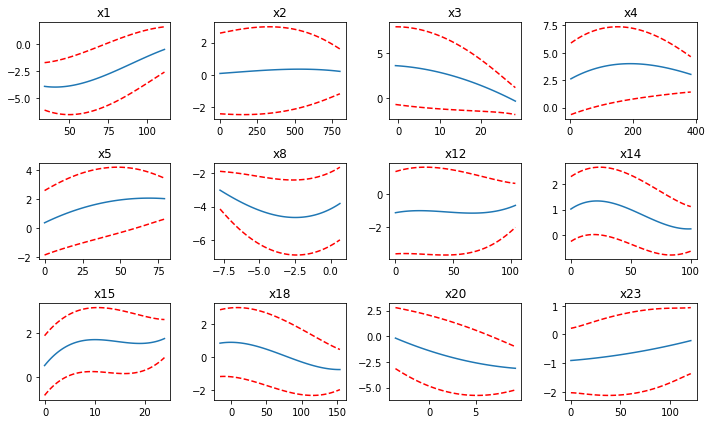

In [46]:
# plotting
fig, axs = plt.subplots(3,4,figsize=(10,6))
names = df_test_clean.columns[1:].values
for i, ax in enumerate(axs.flatten()):
    XX = p_spl.generate_X_grid(term=i)
    plt.subplot(ax)
    plt.plot(XX[:, i], p_spl.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], p_spl.partial_dependence(term=i, X=XX, width=.95)[1], c='r', ls='--')
    plt.title(names[i])
plt.tight_layout()

In [47]:
p_spl.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     28.4902
Link Function:                        LogitLink Log Likelihood:                                 -4206.6159
Number of Samples:                         7896 AIC:                                             8470.2121
                                                AICc:                                            8470.4407
                                                UBRE:                                               3.0756
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2308
Feature Function                  Lam

The partial dependence plot of GAM agrees with the other models.

We can see that the GAM also agrees significant variables `x1`,`x15`,`x8`,`x18`,and `x4`.
GAM also agrees on the effect directions.

Therefore, we conclude that our base benchmark agrees with the interpretation of other models selected.

# Conclusion

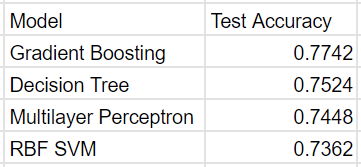

From the above accuracy table, we can found that the simple decision tree outperformed the more complex models (MLP-NN and GAM) with a high testing accuracy of 0.75 and much better explainability. When we compare the decision tree model with the gradient boosting model, we found that the accuracy of gradient boosting model is higher and the lost of explainability is acceptable. Thus, we choose the gradient model as our final model.

From the post-hoc analysis, we found the top 5 most important variables are the same for all models in our final list, indicating the robustness of their importance.